In [8]:
import sys
!{sys.executable} -m pip install pymc3

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# If I'm able to access packages install on my ncar_pylib_clone, why does python point to the jupyterhub directory?
# What is the origin of the ctsm kernel? It must have been installed while I was in the NPL clone environment.
!which python
!type python

/ncar/usr/jupyterhub/20190118/bin/python
python is /ncar/usr/jupyterhub/20190118/bin/python


In [4]:
# The notebook bash environment is different than my default environment on cheyenne
!module list
!echo $SHELL
!echo $PATH
!which g++
!which c++
!which mpiexec_mpt

No modules loaded
>/bin/bash
/opt/pbs/bin:/ncar/usr/jupyterhub/20190118/bin:/glade/u/apps/ch/opt/lmod/7.2.1/bin:/usr/sbin:/usr/bin:/sbin:/bin
/usr/bin/g++
/usr/bin/c++
which: no mpiexec_mpt in (/opt/pbs/bin:/ncar/usr/jupyterhub/20190118/bin:/glade/u/apps/ch/opt/lmod/7.2.1/bin:/usr/sbin:/usr/bin:/sbin:/bin)


In [2]:
import numpy as np

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [11]:
import corner

In [12]:
# Testing the use of a package installed on my ncar_pylib_clone
# Somehow it finds these packages, I think because the kernel was set up from my clone environment
from pyDOE import *
lhd = lhs(6, samples=int(2))
print(lhd)

[[0.69375367 0.42105    0.91721816 0.77759723 0.21895175 0.93337673]
 [0.30580988 0.50947902 0.15489656 0.04253279 0.85599774 0.38098259]]


In [18]:
# Still having intermittent trouble with this import function
import pymc3 as pymc

In [1]:
# Try emcee due to syntax differences with pymc2/3
import emcee

In [27]:
# Test out some emcee functionality
def lnprob(x, ivar):
    return -0.5 * np.sum(ivar * x ** 2)

ndim, nwalkers = 10, 100
ivar = 1. / np.random.rand(ndim)
p0 = [np.random.rand(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[ivar])
sampler.run_mcmc(p0, 1000)

(array([[-4.84911180e-01,  5.23559772e-01, -6.84284281e-01,
          7.46121566e-01,  9.25262190e-01,  2.09843366e-01,
         -1.61351475e-01, -2.03373345e-01,  1.62108658e-01,
          1.40942429e-01],
        [ 1.31121270e+00,  1.56826304e+00,  5.69457629e-03,
         -1.24202406e+00,  6.99296063e-01,  3.00786738e-01,
         -8.79644308e-01, -1.31716187e-01, -1.22857956e+00,
          4.76476261e-01],
        [ 2.45680338e-01,  1.30570715e+00,  2.46008481e-01,
          1.74177215e-01,  9.66427927e-02, -2.90050124e-01,
         -2.96828767e-01,  1.54129182e-01, -1.93524473e-01,
         -2.44425530e-01],
        [ 7.54271962e-01,  5.09357184e-01,  1.65376508e-01,
          1.01728118e+00, -1.61988510e+00, -2.06369522e+00,
         -4.33884528e-01, -5.70571444e-01,  3.04124460e-01,
         -2.74072186e-01],
        [-8.46663918e-01,  1.02172764e+00, -5.76634317e-01,
         -4.20105787e-01, -1.17462550e+00, -1.02068701e+00,
         -6.34679044e-01, -6.59105089e-01, -5.619925

In [13]:
# Original order of loading modules
#import pymc3
#import numpy as np
#import matplotlib
#import matplotlib.pyplot as plt
#import matplotlib.cm as cm
#import corner
#%matplotlib inline

## Simple MCMC notebook for two-term power law 
$$ Y = a_1 X**b_1 + a_2 X**b_2 $$
Find a1, b1, a2, b2 given some uncertain obs of Y over some values of X

In [14]:
#..Set up simple power law model function
def two_term_one_dim(a1,a2,b1,b2,xvec):
    pvec = a1*xvec**b1 + a2*xvec**b2
    return pvec

In [15]:
#..Test out this function for from values of xvec
xvec = np.linspace(0.1,100.,500)
pvec = two_term_one_dim(20.,1.,0.1,0.9,xvec)


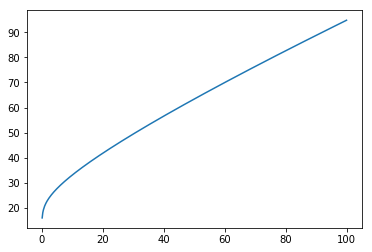

In [16]:
plt.plot(xvec,pvec)

In [19]:
# #..Define variables and priors (bounded uniform)
# a1 = pymc.Uniform('a1',0.,40.)
# a2 = pymc.Uniform('a2',0.,2.)
# b1 = pymc.Uniform('b1',-1.0,1.0)
# b2 = pymc.Uniform('b2',-2.0,2.0)

#..Define variables and priors (bounded uniform, you can try Gaussian too)
a1 = pymc.Uniform('a1',15.,25.)
a2 = pymc.Uniform('a2',0.7,1.3)
b1 = pymc.Uniform('b1',-0.3,0.3)
b2 = pymc.Uniform('b2',0.3,1.3)

#..Define the observation points and the "true" observation
xvec = np.arange(2.0,21.,2)
print(xvec)
truth = np.array([20.,1.,0.1,0.9])
ydata = two_term_one_dim(truth[0],truth[1],truth[2],truth[3],xvec)
print(ydata)

#..Define the model
@pymc.deterministic
def y_model(a1=a1, a2=a2, b1=b1, b2=b2, xvec = xvec):
    pvec = two_term_one_dim(a1,a2,b1,b2,xvec)
    return pvec

#..Define the obs error standard deviation
sigma = 0.02

#..Define the likelihood (multivariate Gaussian w/ diagnonal error variance)
y = pymc.MvNormalCov('y',mu=y_model, C=sigma**2*np.eye(xvec.shape[0]), observed=True, value=ydata)

#..Bundle everything into a dict
model = dict(a1=a1,a2=a2,b1=b1,b2=b2,y_model=y_model,y=y)

TypeError: No model on context stack, which is needed to instantiate distributions. Add variable inside a 'with model:' block, or use the '.dist' syntax for a standalone distribution.

In [ ]:
#..Run using the standard sampler (metropolis sampler with burn-in) w/independent proposal
S = pymc.MCMC(model)
S.sample(iter=2000000, burn=50000)

In [ ]:
#..Run using the Adaptive Metropolis sampler (Haario 2001) w/covarying proposal
#..NOTE: you may need to run the cell two before this again to get this to work
S = pymc.MCMC(model)
S.use_step_method(pymc.AdaptiveMetropolis, [S.a1,S.a2,S.b1,S.b2], delay=10000)
S.sample(iter=2000000, burn=500000)

In [ ]:
#..Some stats
plt.hist(S.trace('y_model')[:,0],bins=40)

In [ ]:
#..Plot the posterior joint parameter PDF (as a 2D and 1D marginal corner plot)

labels  = ['$a_1$', '$a_2$','$b_1$','$b_2$']
#samples = np.vstack((S.trace('a1')[:],S.trace('a2')[:],S.trace('b1')[:],S.trace('b2')[:]))
samples = np.vstack((S.trace('a2')[:],S.trace('a1')[:],S.trace('b2')[:],S.trace('b1')[:]))
print(samples.shape)

#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(5,5,1)
#plt.plot([0,1],[0,1])
label_kwargs = {'fontsize':'20'}
#fig = triangle.corner(samples.T,labels=labels,truths=truth,label_kwargs=label_kwargs)
# fig,axes = triangle.corner(samples.T,labels=labels,truths=truth,
#                       quantiles=[.1,.5,.9],truth_color='r',
#                       show_titles=True,
#                       bins=50,
#                       label_kwargs=label_kwargs,return_axes=True)


#..NOTE the default behavior only returns fig
#fig,axes = corner.corner(samples.T,labels=labels,truths=truth,
fig = corner.corner(samples.T,labels=labels,truths=truth,
                      quantiles=[.1,.5,.9],truth_color='r',
                      show_titles=True,
                      bins=50,
                      label_kwargs=label_kwargs)
fig.set_size_inches(9,8)

fig.savefig('mcmc_twoterm_lowerr10.png',dpi=150)
#fig.suptitle('Damped Harmonic Oscillator parameter uncertainty', fontsize=22,fontweight='bold',y=1.05)
#fig.savefig('mcmc_dampharm.png',dpi=150)